In [3]:
import pandas as pd
import pybedtools as pbt
import fanc
import fanc.plotting as fancplot
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import multiprocessing as mp
import traceback
import tempfile
import glob
import re
import os
from fanc.architecture.aggregate import loop_strength
import scikit_posthocs
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline

In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be remove

In [10]:
### Helper function to make contingency tables, chisquare and post-hoc chisquare test

def contingencyAnalysis(df,var1,var2):
    contingency = pd.crosstab(df[var1],df[var2])
    c, p, dof, expected = stats.chi2_contingency(contingency)
    norm_contingency = (pd.DataFrame({"frequency":contingency.apply(lambda x:(x/x.sum())*100,axis=1)[True]}).
                        reset_index())
    all_combinations = list(combinations(contingency.index, 2))
    chiList = []
    for comb in all_combinations:
        pairwise_contingency = contingency[(contingency.index == comb[0]) | (contingency.index == comb[1])]
        chi2, p, dof2, ex = stats.chi2_contingency(pairwise_contingency, correction=False)
        chiList.append([*comb,p])
    posthoc_chi = pd.DataFrame(chiList,columns=["category1","category2","pval"])
    reject_list, corrected_p_vals = multipletests(posthoc_chi["pval"], method='fdr_bh')[:2]
    posthoc_chi["fdr"] = corrected_p_vals
    contingencyAnalysis = {"p-value":p,"contingency":norm_contingency,"posthoc":posthoc_chi,"dof":dof}
    return(contingencyAnalysis)
    

In [3]:
Loops =  pd.read_csv("../data/bonev/HiC/ES_mapq30/loops/merged_loops-fix.bedpe",
                     sep="\t")
Loops = Loops.sort_values(["chr1","x1","chr2","x2"])

In [4]:
hicfile = "../data/bonev/HiC/ES_mapq30/ES_mapq30.hic@10000@NONE"
hic = fanc.load(hicfile)

In [5]:
chromsizes = "../data/genomes/mm10.big.ensembl.sizes"

#### 1. Create Loop and Loop anchor datasets

In [6]:
Anchors1 = Loops[["chr1","x1","x2"]]
Anchors2 = Loops[["chr2","y1","y2"]]
anchorCols = ["chrom","start","end"]
Anchors1.columns = anchorCols
Anchors2.columns = anchorCols
Anchors = pd.concat([Anchors1,Anchors2])

Merge bookended loopanchors

In [7]:
Anchors = Anchors.drop_duplicates()
Anchors = (pbt.BedTool().
           from_dataframe(Anchors).
           sort().
           cluster().
           to_dataframe())

In [8]:
anchorDict = Anchors.set_index(["chrom","start","end"])["name"].to_dict()
anchorMergedCoordsDict = Anchors.groupby("name").agg({"start":min,"end":max}).to_dict()

Update new loopAnchor coords in Loop dataset and merge loops as required

In [9]:
Loops["Anchor1"] = Loops[["chr1","x1","x2"]].apply(lambda x:anchorDict[(x[0],x[1],x[2])],axis=1)
Loops["Anchor2"] = Loops[["chr2","y1","y2"]].apply(lambda x:anchorDict[(x[0],x[1],x[2])],axis=1)

In [10]:
Loops = Loops[["chr1","x1","x2","chr2","y1","y2","Anchor1","Anchor2","observed","numCollapsed","centroid1","centroid2"]]

In [11]:
Loops = Loops.groupby(["chr1","Anchor1","Anchor2"]).agg({"observed":sum,
                                                  "numCollapsed":sum,
                                                  "centroid1":min,
                                                  "centroid2":max}).reset_index()

In [12]:
Loops["start1"] = Loops["Anchor1"].apply(lambda x:anchorMergedCoordsDict["start"][x])
Loops["end1"] = Loops["Anchor1"].apply(lambda x:anchorMergedCoordsDict["end"][x])
Loops["start2"] = Loops["Anchor2"].apply(lambda x:anchorMergedCoordsDict["start"][x])
Loops["end2"] = Loops["Anchor2"].apply(lambda x:anchorMergedCoordsDict["end"][x])

#### 2. Incorporate CTCF info inside Loop dataset 

In [13]:
Fimo = pd.read_csv("fimo_out/fimo.tsv",sep="\t",comment="#")
Ctcf = pd.DataFrame()
Ctcf[["chrom","start","end"]] = Fimo["sequence_name"].str.extract("chr(.*):([0-9]*)-([0-9]*)")
Ctcf[["name","score","strand"]] = Fimo[["matched_sequence","score","strand"]]
Ctcf = Ctcf.sort_values(["chrom","start"])

In [14]:
combinedCols = ["anchorChrom","anchorStart","anchorEnd","anchorName",
                "ctcfChrom","ctcfStart","ctcfEnd","ctcfSeq","ctcfScore","ctcfStrand"]

ctcfAnchorDict = (pbt.BedTool().
               from_dataframe(Anchors).
               intersect(pbt.BedTool().from_dataframe(Ctcf),wa=True,wb=True).
               to_dataframe(names=combinedCols).
               groupby("anchorName").
               agg({"ctcfStrand":lambda x:"".join(sorted(pd.unique(x)))})["ctcfStrand"].
               to_dict())



In [15]:
Loops["ctcf1"] = Loops["Anchor1"].map(ctcfAnchorDict)
Loops["ctcf2"] = Loops["Anchor2"].map(ctcfAnchorDict)
Loops["ctcf"] = Loops["ctcf1"] + "_" + Loops["ctcf2"]

/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ctcf', ylabel='count'>

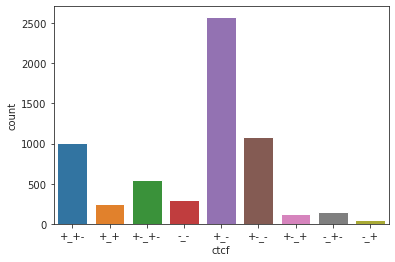

In [16]:
sns.countplot(Loops["ctcf"])

#### 3. Classify anchors in -ctcf,canonical and non-canonical and in bidirectional and not

In [17]:
nonCtcfAnchors = set(Loops.query("ctcf1!=ctcf1")["Anchor1"].values.tolist() + Loops.query("ctcf2!=ctcf2")["Anchor2"].values.tolist())
bothSideAnchors = set(Loops.loc[Loops["Anchor1"].isin(Loops["Anchor2"])]["Anchor1"])
wrongAnchors = set(Loops.query("ctcf1=='-'")["Anchor1"].values.tolist() + Loops.query("ctcf2=='+'")["Anchor2"].values.tolist())

In [18]:
Anchors = Anchors.groupby(["chrom","name"]).agg({"start":"min","end":"max"}).reset_index()

In [19]:
def kindLoop(x):
    if x in nonCtcfAnchors:
        return("no-ctcf")
    elif x in wrongAnchors:
        return("wrong")
    else:
        return("right")
    
Anchors["kind"] = Anchors["name"].map(kindLoop)
Anchors["bothSide"] = Anchors["name"].isin(bothSideAnchors)

/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '')

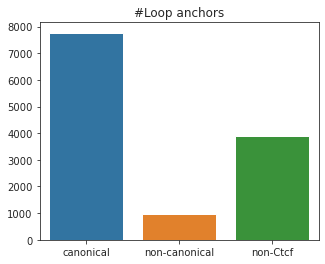

In [20]:
plt.figure(figsize=(5,4))
ax = sns.countplot(Anchors["kind"])
ax.set_title("#Loop anchors")
ax.set_xticklabels(["canonical","non-canonical","non-Ctcf"])
ax.set_ylabel("")
ax.set_xlabel("")

In [22]:
(Anchors["kind"]=="wrong").mean()

0.07597942223981005

In [27]:
anchorsVSbidirectional = contingencyAnalysis(Anchors,"kind","bothSide") 

In [29]:
anchorsVSbidirectional["p-value"]

5.7997679730652355e-285

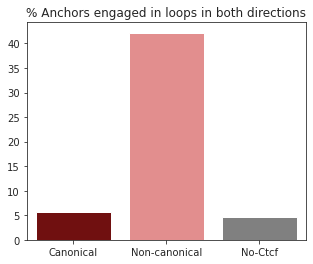

In [31]:
plt.figure(figsize=(5,4))
ax = sns.barplot(data=anchorsVSbidirectional["contingency"],x="kind",y="frequency",order=["right","wrong","no-ctcf"],palette=["maroon","lightcoral","gray"])
ax.set_title("% Anchors engaged in loops in both directions")
ax.set_xticklabels(["Canonical","Non-canonical","No-Ctcf"])
ax.set_ylabel("")
ax.set_xlabel("")
plt.savefig("figurePlots/BidirectionalAnchors.pdf")

In [32]:
anchorsVSbidirectional["posthoc"]

category1 category2           pval            fdr
0   no-ctcf     right   1.795310e-02   1.795310e-02
1   no-ctcf     wrong  4.054878e-225  6.082318e-225
2     right     wrong  5.799768e-285  1.739930e-284

In [21]:
Loops.to_csv("4-NC_Loops/LoopsWithCtcfInfo.tsv",sep="\t",index=False)

#### 4.Categorize ctcf-loops in canonical categories

In [22]:
ctcfLoops = Loops.query("ctcf==ctcf").copy()
ctcfLoops["canonical"] = np.logical_and(ctcfLoops["ctcf1"]!="-",ctcfLoops["ctcf2"]!="+")

In [23]:
canonicalAnchor1Set = set(ctcfLoops.query("canonical")["Anchor1"])
canonicalAnchor2Set = set(ctcfLoops.query("canonical")["Anchor2"])

In [257]:
len(ctcfLoops)

6078

In [24]:
def loopSet(x):
    if x["ctcf1"]=="-":
        if x["Anchor1"] in canonicalAnchor2Set:
            return("non-canonical_associated")
        else:
            return("non-canonical")
    elif x["ctcf2"]=="+":
        if x["Anchor2"] in canonicalAnchor1Set:
            return("non-canonical_associated")
        else:
            return("non-canonical")
    elif (x["Anchor1"] in wrongAnchors) or (x["Anchor2"] in wrongAnchors):
        return("canonical_associated")
    else:
        if (x["Anchor1"] in bothSideAnchors) or (x["Anchor2"] in bothSideAnchors):
            return("double-sided_canonical")
        else:
            return("single-sided_canonical")
        

In [25]:
ctcfLoops["loopSet"] = ctcfLoops.apply(loopSet,axis=1)

<AxesSubplot:xlabel='count', ylabel='loopSet'>

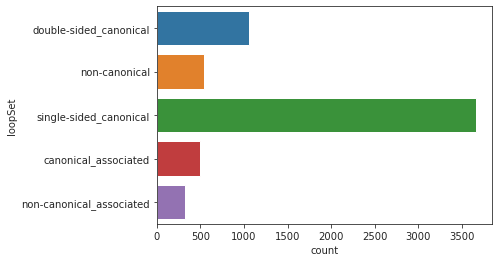

In [26]:
sns.countplot(data=ctcfLoops,y="loopSet")

#### 5.Loop strength and aggregate loop analysis

Open up window of +-150kb from the center of both loop anchors

In [27]:
loopSetFancDict = {}
windowSize = 150000

for loopSet,df in ctcfLoops.groupby("loopSet"):
    filename = "4-NC_Loops//{}.bedpe".format(loopSet)
    df = df.copy()
    center1 = (df["start1"]+df["end1"])//2
    center2 = (df["start2"]+df["end2"])//2
    df["aggStart1"] = center1-windowSize
    df["aggEnd1"] = center1+windowSize
    df["aggStart2"] = center2 -windowSize
    df["aggEnd2"] = center2 + windowSize
    df[["chr1","aggStart1","aggEnd1","chr1","aggStart2","aggEnd2"]].to_csv(filename,sep="\t",index=False,header=False)
    loopSetFancDict[loopSet] = fanc.load(filename)

In [28]:
def aggLoops(name,loops):
    try:
        prefix = os.path.splitext(loops.fn)[0]
        matfile = prefix + ".mat"
        with np.errstate(divide='ignore'):
            am = fanc.AggregateMatrix.from_center_pairs(hic, loops.region_pairs(),pixels=32)
        np.savetxt(matfile,am.matrix())
        return([name,matfile])
    except Exception as e:
        print('Caught exception in worker thread (x = {}):'.format(name))
        traceback.print_exc()
        print()
        raise e

def aggCallBack(item):
    amSetDict[item[0]]=item[1]

Calculate aggregate Loops

In [29]:
ncpus = 5
pool = mp.Pool(processes=ncpus)
amSetDict = {}

for name,loops in loopSetFancDict.items():
    pool.apply_async(aggLoops,args=[name,loops],callback=aggCallBack)

pool.close()
pool.join()

Matrices 100% (498 of 498) |#############| Elapsed Time: 0:52:42 Time:  0:52:42
Matrices 100% (322 of 322) |#############| Elapsed Time: 0:52:51 Time:  0:52:51
Matrices 100% (3656 of 3656) |###########| Elapsed Time: 0:53:38 Time:  0:53:38
Matrices 100% (541 of 541) |#############| Elapsed Time: 0:54:41 Time:  0:54:41
Matrices 100% (1061 of 1061) |###########| Elapsed Time: 0:55:09 Time:  0:55:09


In [31]:
amSetDict = {}

for file in glob.glob("4-NC_Loops/*mat"):
    match = re.search("/(.*).mat",file)
    amSetDict[match.group(1)]=file

In [34]:

loopSetCounts = ctcfLoops["loopSet"].value_counts()

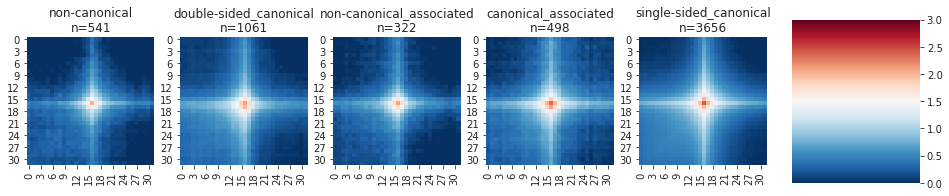

In [72]:
fig, ax = plt.subplots(1,6,figsize=(16,3))

for i,(loopSet,matfile) in enumerate(amSetDict.items()):
    mat = np.loadtxt(matfile)
    sns.heatmap(mat,cmap="RdBu_r",ax=ax[i],square=True,vmax=3,vmin=0,cbar_ax=ax[5])
    ax[i].set_title("{}\nn={}".format(loopSet,loopSetCounts[loopSet]))

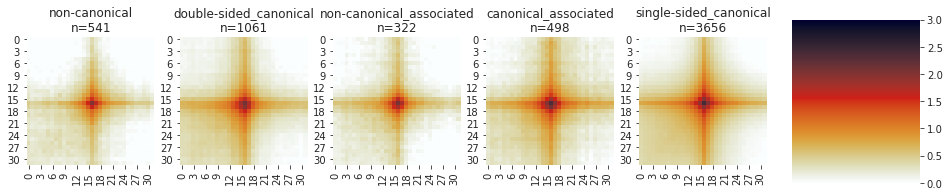

In [134]:
fig, ax = plt.subplots(1,6,figsize=(16,3))

for i,(loopSet,matfile) in enumerate(amSetDict.items()):
    mat = np.loadtxt(matfile)
    sns.heatmap(mat,cmap="germany",ax=ax[i],square=True,vmax=3,vmin=0,cbar_ax=ax[5])
    ax[i].set_title("{}\nn={}".format(loopSet,loopSetCounts[loopSet]))
    
plt.savefig("figurePlots/LoopAggregates.pdf")

Calculate Loop strength

In [38]:
loopStrengthList = []

def loopStrength(loops):
    try:
        tmp = tempfile.NamedTemporaryFile(delete=False,suffix=".bedpe")
        tmp.close()
        loops[["chr1","start1","end1","chr1","start2","end2"]].to_csv(tmp.name,sep="\t",
                                                                      index=False,header=False)
        fancloops = fanc.load(tmp.name)
        ls = loop_strength(hic,fancloops.region_pairs())
        loops["LS"] = ls
        os.unlink(tmp.name)
        return(loops)
    except Exception as e:
        print('Caught exception in worker thread')
        traceback.print_exc()
        print()
        raise e

def LS_callback(loops):
    loopStrengthList.append(loops)

In [45]:
ncpus = 128
pool = mp.Pool(processes=ncpus)

for df in np.array_split(ctcfLoops,ncpus):
    pool.apply_async(loopStrength,args=[df],callback=LS_callback)

pool.close()
pool.join()

Matrices 100% (144 of 144) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (144 of 144) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (144 of 144) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (141 of 141) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (141 of 141) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (141 of 141) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (144 of 144) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (141 of 141) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (144 of 144) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (144 of 144) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (144 of 144) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (144 of 144) |#############| Elapsed Time: 0:00:01 Time:  0:00:01
Matrices 100% (144 of 144) |############

In [47]:
ctcfLoopsWithStrength = pd.concat(loopStrengthList)

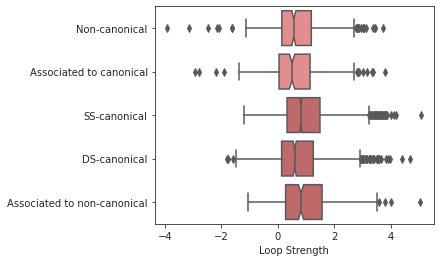

In [164]:
plt.figure(figsize=(5,4))
ax = sns.boxplot(data=ctcfLoopsWithStrength,y="loopSet",x="LS",
            palette=["lightcoral","lightcoral","indianred","indianred","indianred"],
            notch=True,order=["non-canonical",
                              "non-canonical_associated",
                              "single-sided_canonical",
                              "double-sided_canonical", 
                              "canonical_associated"])
plt.xlabel("Loop Strength")
ax.set_yticklabels(["Non-canonical","Associated to canonical","SS-canonical","DS-canonical","Associated to non-canonical"])
plt.ylabel("")
plt.savefig("figurePlots/LoopStrength.pdf",bbox_inches="tight")

In [75]:
strengthArrays = dict(list(ctcfLoopsWithStrength.groupby("loopSet")["LS"]))
stats.kruskal(*strengthArrays.values())

KruskalResult(statistic=109.85838630041596, pvalue=7.801768753984168e-23)

In [69]:
ph = scikit_posthocs.posthoc_mannwhitney(ctcfLoopsWithStrength,
                                         val_col="LS",
                                         group_col="loopSet",
                                         p_adjust="fdr_bh")
ph

canonical_associated  double-sided_canonical  \
canonical_associated                  1.000000            6.993807e-05   
double-sided_canonical                0.000070            1.000000e+00   
non-canonical                         0.000050            6.182708e-01   
non-canonical_associated              0.000006            1.052130e-01   
single-sided_canonical                0.757227            1.687900e-12   

                          non-canonical  non-canonical_associated  \
canonical_associated       4.967980e-05              6.296614e-06   
double-sided_canonical     6.182708e-01              1.052130e-01   
non-canonical              1.000000e+00              2.896466e-01   
non-canonical_associated   2.896466e-01              1.000000e+00   
single-sided_canonical     3.508349e-10              3.508349e-10   

                          single-sided_canonical  
canonical_associated                7.572271e-01  
double-sided_canonical              1.687900e-12  
non-canonical                       3.508349e-10  
non-canonical_associated            3.508349e-10  
single-sided_canonical              1.000000e+00

In [53]:
ctcfLoopsWithStrength.groupby("loopSet").aggregate({"LS":np.median})

LS
loopSet                           
canonical_associated      0.818147
double-sided_canonical    0.595320
non-canonical             0.562790
non-canonical_associated  0.501948
single-sided_canonical    0.811309

#### 6. Association with boundaries

In [33]:
Boundaries = (pbt.BedTool("2.CTCF-insulation/Bonev_mESc_25kb_iw250kb_boundaries.bed").
              slop(b=50000,g=chromsizes).
              to_dataframe(names=["chrom","start","end","name","BS","strand"]))
Boundaries.query("BS>1")
Boundaries = pbt.BedTool().from_dataframe(Boundaries)


Anchor1Boundary = (pbt.BedTool().
                   from_dataframe(Loops[["chr1","start1","end1","Anchor1"]]).
                   intersect(Boundaries,wa=True).
                   to_dataframe()["name"])

Anchor2Boundary = (pbt.BedTool().
                   from_dataframe(Loops[["chr1","start2","end2","Anchor2"]]).
                   intersect(Boundaries,wa=True).
                   to_dataframe()["name"])

boundaryAnchors = set(Anchor1Boundary.values.tolist()+Anchor2Boundary.values.tolist())

In [37]:
ctcfLoopsWithStrength["cornerLoop"] = np.logical_and(ctcfLoopsWithStrength["Anchor1"].isin(boundaryAnchors),
                                     ctcfLoopsWithStrength["Anchor2"].isin(boundaryAnchors))



In [11]:
loopSetVsBoundaries = contingencyAnalysis(ctcfLoopsWithStrength,"loopSet","cornerLoop")

In [12]:
loopSetVsBoundaries["dof"]

4

In [8]:
loopSetVsBoundaries["p-value"]

1.1007093696177802e-05

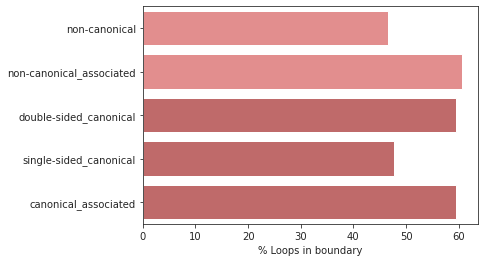

In [51]:
sns.barplot(data = loopSetVsBoundaries["contingency"],x="frequency",y="loopSet",
            palette=["lightcoral","lightcoral","indianred","indianred","indianred"],
            order=["non-canonical",
                   "non-canonical_associated",
                   "double-sided_canonical",
                   "single-sided_canonical", 
                   "canonical_associated"])
plt.ylabel("")
plt.xlabel("% Loops in boundary")
plt.savefig("figurePlots/LoopsInBoundary.pdf",bbox_inches="tight")

In [52]:
loopSetVsBoundaries["posthoc"]

category1                 category2          pval  \
0      canonical_associated    double-sided_canonical  9.615016e-01   
1      canonical_associated             non-canonical  3.367577e-05   
2      canonical_associated  non-canonical_associated  7.490435e-01   
3      canonical_associated    single-sided_canonical  1.060778e-06   
4    double-sided_canonical             non-canonical  7.699531e-07   
5    double-sided_canonical  non-canonical_associated  7.503538e-01   
6    double-sided_canonical    single-sided_canonical  1.402939e-11   
7             non-canonical  non-canonical_associated  7.049283e-05   
8             non-canonical    single-sided_canonical  6.007258e-01   
9  non-canonical_associated    single-sided_canonical  1.100709e-05   

            fdr  
0  9.615016e-01  
1  6.735153e-05  
2  8.337265e-01  
3  3.535926e-06  
4  3.535926e-06  
5  8.337265e-01  
6  1.402939e-10  
7  1.174880e-04  
8  8.337265e-01  
9  2.751773e-05

In [132]:
ctcfLoopsWithStrength.to_csv("4-NC_Loops/LoopsWithLS.tsv",sep="\t",index=False)

In [4]:
ctcfLoopsWithStrength = pd.read_csv("4-NC_Loops/LoopsWithLS.tsv",sep="\t")

In [203]:
ctcfLoopsWithStrength[["chr1","centroid1","centroid2","loopSet"]].c("4-NC_Loops/all_loops.bed",sep="\t",header=False,index=False)

#### 7.Loop distance

In [54]:
ctcfLoopsWithStrength["dist"] = ctcfLoopsWithStrength["centroid2"]-ctcfLoopsWithStrength["centroid1"]

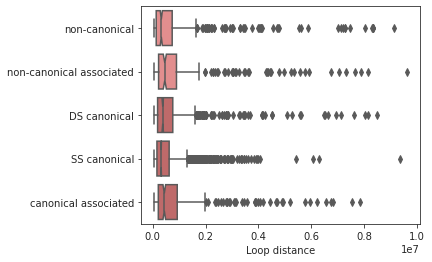

In [55]:
plt.figure(figsize=(5,4))
ax = sns.boxplot(data=ctcfLoopsWithStrength,y="loopSet",x="dist",
            palette=["lightcoral","lightcoral","indianred","indianred","indianred"],
            notch=True,order=["non-canonical",
                              "non-canonical_associated",
                              "double-sided_canonical",
                              "single-sided_canonical",
                              "canonical_associated"])
plt.xlabel("Loop distance")
ax.set_yticklabels(["non-canonical","non-canonical associated","DS canonical","SS canonical","canonical associated"])
plt.ylabel("")
plt.savefig("figurePlots/LoopDist.pdf",bbox_inches="tight")

In [56]:
strengthArrays = dict(list(ctcfLoopsWithStrength.groupby("loopSet")["dist"]))
stats.kruskal(*strengthArrays.values())

KruskalResult(statistic=80.82325270003777, pvalue=1.1656709092223186e-16)

In [57]:
ph = scikit_posthocs.posthoc_mannwhitney(ctcfLoopsWithStrength,
                                         val_col="dist",
                                         group_col="loopSet",
                                         p_adjust="fdr_bh")
ph

canonical_associated  double-sided_canonical  \
canonical_associated              1.000000e+00                0.013533   
double-sided_canonical            1.353287e-02                1.000000   
non-canonical                     7.392899e-05                0.015501   
non-canonical_associated          7.476908e-01                0.013533   
single-sided_canonical            3.465211e-10                0.000002   

                          non-canonical  non-canonical_associated  \
canonical_associated           0.000074              7.476908e-01   
double-sided_canonical         0.015501              1.353287e-02   
non-canonical                  1.000000              1.130165e-04   
non-canonical_associated       0.000113              1.000000e+00   
single-sided_canonical         0.747691              4.854125e-08   

                          single-sided_canonical  
canonical_associated                3.465211e-10  
double-sided_canonical              2.422701e-06  
non-canonical                       7.476908e-01  
non-canonical_associated            4.854125e-08  
single-sided_canonical              1.000000e+00